# Import

In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


# Chargement des données et prétraitement

In [16]:
def preProcessDataframe(df: object) -> object:
    dfret = df.dropna(subset = [
        "station_id", 
        "lat", 
        "lon", 
        "occupation_prct", 
        "occupation_class"
    ]).copy()
    
    dfret['jour'] = dfret["time"].dt.day
    dfret['heure'] = dfret["time"].dt.hour
    dfret['minute'] = dfret["time"].dt.minute
    
    return dfret

In [17]:
df0 = dst.getDataset("2023_03_17")
df1 = dst.getDataset("2023_03_18")
df2 = dst.getDataset("2023_03_19")
df3 = dst.getDataset("2023_03_20")
df4 = dst.getDataset("2023_03_21")

#Je réduis systématiquement la résolution en temps par 10 sur ce classeur
step=10
df0=df0.iloc[0::step]
df1=df1.iloc[0::step]
df2=df2.iloc[0::step]
df3=df3.iloc[0::step]
df4=df4.iloc[0::step]


df0=preProcessDataframe(df0)
df1=preProcessDataframe(df1)
df2=preProcessDataframe(df2)
df3=preProcessDataframe(df3)
df4=preProcessDataframe(df4)

In [19]:
#On vérifie que prendre une ligne sur 10 laisse un meme nombre de points par station
df=df1
station_list=list(set(df.station_id))
Nst=len(station_list)
Nt=len(set(df[df['station_id'] == station_list[0]].time))
station_timeserie=np.ndarray([Nst,Nt])

foo=[]
for i in station_list : 
    foo.append(len(set(df[df['station_id'] == i]) ))
print(np.min(foo) , np.max(foo) )

22 22


In [34]:
## Ajout de valeurs d'occupation 6h plus tot :
def add_old_values(df, df_old=None):
    dec=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    
    if df_old is None:
        df_main=df.copy()
    else : 
        df_main=pd.concat([df_old, df])
        
#     df2=df.shift()
    df_join=df_main[['time','station_id','occupation_prct','occupation_class']].copy()
    df_join['time']=df_join['time']+pd.Timedelta(hours=6)
    df_join=df_join.rename(columns={"time": "old_time", "occupation_prct": "old_occupation_prct", 
                                    "occupation_class": "old_occupation_class"})

    df_main=pd.merge_asof(df_main.sort_values('time'), df_join.sort_values('old_time'), 
                          by='station_id', left_on='time', right_on='old_time', direction='nearest')
#     df_main.drop('old_time')
    
    df_main=df_main[df_main['jour'] == df.loc[0,'jour']]
    
    
    return df_main


In [68]:
## Ajout de valeurs d'occupation 6h plus tot :
def add_old_values(df, df_old=None):
    dec=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    
    if df_old is None:
        df_main=df.copy()
    else : 
        df_main=pd.concat([df_old, df])
        
    df_main["old_occupation_class"]=df_main["occupation_class"].shift(periods=dec, axis=0)
    df_main["old_occupation_prct"]=df_main["occupation_prct"].shift(periods=dec, axis=0)

    
    df_main=df_main[df_main['jour'] == df['jour'].median()]
    
    
    return df_main


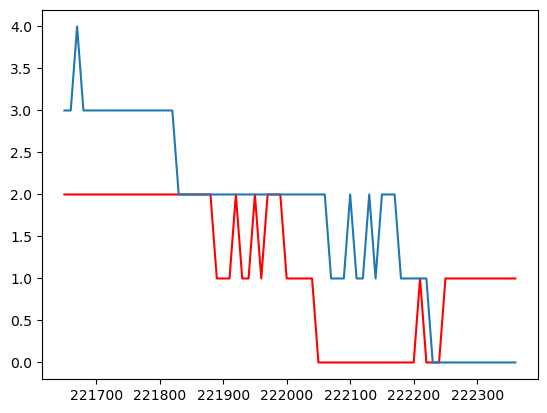

In [74]:
foo=add_old_values(df3, df2)
plt.plot(foo[foo['station_id'] == station_list[0]].occupation_class, color='r')
plt.plot(foo[foo['station_id'] == station_list[0]].old_occupation_class)

In [67]:
df4=add_old_values(df4, df3)
df3=add_old_values(df3, df2)
df2=add_old_values(df2, df1)
df1=add_old_values(df1, df0)
df0=add_old_values(df0)
df0=df0.dropna(subset=['old_occupation_prct','old_occupation_class'])

,station_id,num_bikes_available,num_bikes_available_mech,num_bikes_available_elec,num_docks_available,is_installed,is_returning,is_renting,last_reported,time,...,name,lat,lon,capacity,occupation_prct,occupation_class,seconds_since_midnight,jour,heure,minute
0,213688169,6,2.0,4.0,29,1,1,1,1679264946,2023-03-20 00:00:18,...,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,17.142857,1,18,20,0,0
10,213688169,5,2.0,3.0,30,1,1,1,1679264946,2023-03-20 00:20:19,...,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714,1,1219,20,0,20
20,213688169,5,2.0,3.0,30,1,1,1,1679268594,2023-03-20 00:40:20,...,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714,1,2420,20,0,40
30,213688169,5,2.0,3.0,30,1,1,1,1679268594,2023-03-20 01:00:21,...,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714,1,3621,20,1,0
40,213688169,5,2.0,3.0,30,1,1,1,1679268594,2023-03-20 01:20:22,...,Benjamin Godard - Victor Hugo,48.865983,2.275725,35,14.285714,1,4822,20,1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039560,315022587,1,1.0,0.0,63,1,1,1,1679344275,2023-03-20 22:17:55,...,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,1.492537,0,80275,20,22,17
1039570,315022587,2,1.0,1.0,62,1,1,1,1679347756,2023-03-20 22:37:56,...,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,2.985075,0,81476,20,22,37
1039580,315022587,0,0.0,0.0,64,1,1,1,1679347756,2023-03-20 22:57:57,...,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,0.000000,0,82677,20,22,57
1039590,315022587,0,0.0,0.0,64,1,1,1,1679347756,2023-03-20 23:18:59,...,Malesherbes - Place de la Madeleine,48.870406,2.323244,67,0.000000,0,83939,20,23,18


## Entrainement et prédiction

### Toutes les stations

In [91]:
df_train=pd.concat([df0,df1])
df_train=pd.concat([df_train,df2])
df_train=pd.concat([df_train,df3])
# df_tot=pd.concat(df_tot,df4)

df_test=df4


feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
feat2 = feat1+["old_occupation_class"]
target = ["occupation_class"]

x_train1=df_train[feat1]
x_train2=df_train[feat2]
y_train=df_train[target]

x_test1=df_test[feat1]
x_test2=df_test[feat2]
y_test=df_test[target]


In [93]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf1.fit(x_train1, y_train.values.ravel())

clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf2.fit(x_train2, y_train.values.ravel())


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [94]:
y_pred1 = clf1.predict(x_test1)
y_pred2 = clf2.predict(x_test2)


In [95]:
accuracy_score(y_test, y_pred1)

0.4228224809092872

In [96]:
accuracy_score(y_test, y_pred2)

0.4221943032135215

### Une station à la fois

In [159]:
def test_one_class(df_train_in: object, df_test_in, feat_supp=[]) -> None:
    
    station=random.sample(station_list,1)[0]
    print(station)
    
    
    df_train=df_train_in[df_train_in['station_id'] == station]
    df_test=df_test_in[df_test_in['station_id'] == station]

    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["old_occupation_prct", "old_occupation_class"]
    target = ["occupation_class"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())

    clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    clf2.fit(x_train2, y_train.values.ravel())


    y_pred1 = clf1.predict(x_test1)
    y_pred2 = clf2.predict(x_test2)


#     print(feat)
#     print(clf.feature_importances_)

#     cm1 = confusion_matrix(y_test, y_pred1)
    
    
#     cm2 = confusion_matrix(y_test, y_pred2)

#     sns.heatmap(cm1, annot=True, cmap="Blues", fmt="g")
#     sns.heatmap(cm2, annot=True, cmap="Blues", fmt="g")    
    
#     plt.xlabel('Prédictions')
#     plt.ylabel('Valeurs réelles')
#     plt.show()
    
#     print(classification_report(y_test,y_pred1))
#     print(classification_report(y_test,y_pred2))


#     print(len(y_test),len(y_pred1),len(y_pred2))
#     print(type(y_test),len(y_pred1),len(y_pred2))

    plt.plot(y_test.values.ravel(), color='black', label='True')
    plt.plot(y_pred1, color='red', label='Pred. basic')
    plt.plot(y_pred2, color='blue', label='Pred. basic+old values')
    plt.legend()
    plt.show()

#     print(y_test.values.ravel())
#     print('\n')
#     print(y_pred1)
#     print('\n')
#     print(y_pred2)

# test_one(df_train, df_test)

13248144


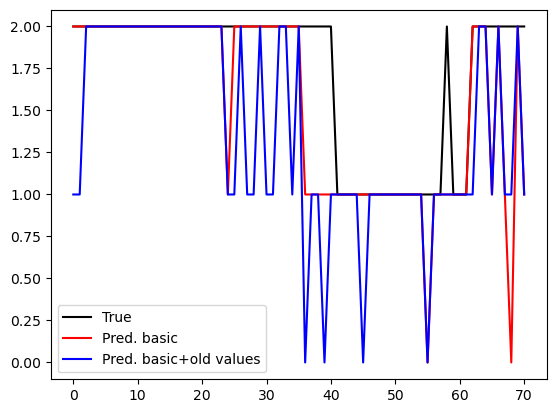

In [160]:
test_one_class(df_train, df_test)

In [157]:
def test_one_regr(df_train_in: object, df_test_in, feat_supp=[]) -> None:
    
    station=random.sample(station_list,1)[0]
    print(station)
    
    
    df_train=df_train_in[df_train_in['station_id'] == station]
    df_test=df_test_in[df_test_in['station_id'] == station]

    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["old_occupation_prct", "old_occupation_class"]
    target = ["occupation_prct"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingRegressor(random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())

    clf2 = GradientBoostingRegressor(random_state=0)
    clf2.fit(x_train2, y_train.values.ravel())


    y_pred1 = clf1.predict(x_test1)
    y_pred2 = clf2.predict(x_test2)

    plt.plot(y_test.values.ravel(), color='black', label='True')
    plt.plot(y_pred1, color='red', label='Pred. basic')
    plt.plot(y_pred2, color='blue', label='Pred. basic+old values')
    plt.legend()
    plt.show()

# test_one(df_train, df_test)

128878135


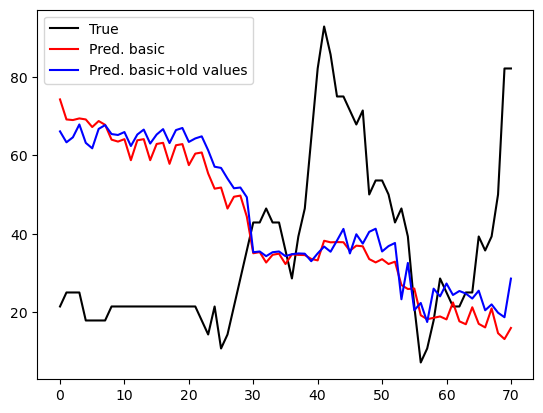

In [158]:
test_one_regr(df_train, df_test)

# Deep learning

On va essayer d'appliquer une régression par RNN ou un CNN (d'abord CNN car il y a un tutorial)

## Feature et target

On met en entrée les valeurs sur x heures avant le temps de la prédiction. Puis la prédiction est encore quelques heures après (6h par exemple).
On fait ça pour chaque temps de la journée.

Les features seront les taux d'occupation, le jour de la semaine, l'heure, l'identifiant de la station.

In [ ]:
#On suppose qu'on a une donnée toutes les 20 minutes
Ntrain=24*3 #On s'entraine sur chaque temps de la journée

Nt=6*3  #On regarde 6 heures avant
Nfeat=4

#Chaque input aura les formes :
# Input shape: (32, 18, 4)
# Labels shape: (32, 18, 1)
# Output shape: (32, 16, 1)

    
def format_input(df):
    
    
    for 

    
    
    

## Modèle

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
